In [254]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(20200305)


In [356]:
games_df = pd.read_csv('../processed_data/games_filtered.csv')

In [357]:
games_df.drop(columns = ['weekly_attendance_ratio'], inplace=True)

In [358]:
home_df = games_df.loc[(games_df['home_team_name'] == 'Cardinals')]

In [352]:
home_df

,year,home_team_name,weekly_attendance,prev_game_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,away_team_wins_last_3,...,zscore_yds_away,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening
43,2010,Cardinals,62439.0,67597.0,False,False,False,False,1.0,1.0,...,1.083097,-0.899316,-0.781831,0.623490,0.000000,1.000000,False,True,False,False
71,2010,Cardinals,62621.0,62439.0,False,True,False,True,1.0,2.0,...,-0.630791,1.618189,-0.781831,0.623490,0.951057,0.309017,False,True,False,False
113,2010,Cardinals,61857.0,62621.0,False,False,False,False,1.0,2.0,...,1.100640,-0.099340,-0.781831,0.623490,0.951057,0.309017,False,True,False,False
140,2010,Cardinals,61904.0,61857.0,False,False,False,False,0.0,1.0,...,2.018358,-0.758130,-0.781831,0.623490,0.587785,-0.809017,False,True,False,False
175,2010,Cardinals,62308.0,61904.0,False,False,False,False,0.0,2.0,...,1.841863,-0.379777,0.000000,1.000000,0.587785,-0.809017,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2389,2019,Cardinals,60140.0,60500.0,False,False,False,False,1.0,0.0,...,0.606018,-1.097888,-0.781831,0.623490,0.951057,0.309017,False,True,False,False
2438,2019,Cardinals,60986.0,60140.0,False,False,False,False,2.0,3.0,...,0.809809,-1.195229,0.433884,-0.900969,0.951057,0.309017,False,False,True,False
2488,2019,Cardinals,60944.0,60986.0,False,False,False,True,0.0,1.0,...,1.568468,-0.970939,-0.781831,0.623490,-0.587785,-0.809017,False,True,False,False
2507,2019,Cardinals,63880.0,60944.0,False,False,False,False,0.0,2.0,...,-1.887555,0.230361,-0.781831,0.623490,-0.587785,-0.809017,False,True,False,False


In [134]:
games_df.columns

Index(['year', 'home_team_name', 'weekly_attendance', 'prev_game_attendance',
       'avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening'],
      dtype='object')

In [359]:
train_df = home_df.loc[(home_df['year'] < 2017)]

In [317]:
class TransitionNet(torch.nn.Module):
    def __init__(self, cov_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(cov_dim, 16)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16, hidden_dim * hidden_dim)
        # self.softmax = torch.nn.Softmax(dim=3)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x= self.fc2(x)
        batch_size = x.size(0)
        
        x = x.view(batch_size, self.hidden_dim, self.hidden_dim)  # [batch, hidden_dim, hidden_dim]
        temperature = 1.5  # try values between 1 and 2
        x = torch.nn.functional.softmax(x/ temperature, dim=-1)  # Row-wise softmax for valid transition matrices
        
        # Optional: blend with identity for numerical stability
        trans_matrix = 0.9 * x + 0.1 * torch.eye(self.hidden_dim)
        return trans_matrix
class Model1(ForecastingModel):
    def __init__(self, cov_dim, hidden_dim=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.trans_net = TransitionNet(cov_dim, hidden_dim)
        

    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        
        batch_shape = zero_data.shape[:-2] 
        
        hidden_dim = self.hidden_dim
        last_year_avg_attendance = covariates[..., 0]
        other_covariates = covariates[..., 1:]

        prediction = last_year_avg_attendance.unsqueeze(-1)  # [T, 1] or [N, T, 1]
        prediction = prediction.expand_as(zero_data)
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_scale = trans_scale + 1e-3
        batch_shape = trans_scale.shape[:-1]  # [N, T]
        init_dist = dist.Normal(0, 10).expand(batch_shape + (hidden_dim,)).to_event(1)
   
        trans_mean = torch.zeros_like(trans_scale)
        trans_dist = dist.Normal(trans_mean, trans_scale).expand(batch_shape + (hidden_dim,)).to_event(1)
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_mean = torch.zeros_like(obs_scale)
        obs_dist = dist.Normal(obs_mean, obs_scale).expand(batch_shape + (1,)).to_event(1)
        trans_logits = self.trans_net(other_covariates)  # [duration, hidden_dim * hidden_dim]
        
            
        trans_matrix_raw = trans_logits.view(duration, hidden_dim, hidden_dim)
    
        trans_matrix=0.9 * trans_matrix_raw + 0.1 * torch.eye(hidden_dim)
        obs_matrix = torch.eye(hidden_dim, 1).expand(*batch_shape, hidden_dim, 1)
        
        if batch_shape:
            trans_matrix = trans_matrix.unsqueeze(0).expand((batch_shape[0], duration, hidden_dim, hidden_dim))
            obs_matrix = torch.eye(hidden_dim, 1).reshape(1, 1, hidden_dim, 1)  # e.g. [1, 1, 3, 1]
            obs_matrix = obs_matrix.expand(batch_shape[0], duration, hidden_dim, 1)  # match batch

            # loc = torch.zeros(batch_shape[0], duration, hidden_dim)
            # scale = torch.full_like(loc, 10.0)
            # init_dist = dist.Normal(loc, scale).to_event(1)
            init_loc = torch.zeros(batch_shape[0], hidden_dim)  # [100, 3]
            init_scale = torch.full((batch_shape[0], hidden_dim), 10.0)  # [100, 3]
            init_dist = dist.Normal(init_loc, init_scale).to_event(1)  # batch_shape [100]

            trans_loc = torch.zeros(batch_shape[0], duration, hidden_dim)
            trans_scale = torch.full_like(trans_loc, 1.0)  # or your current trans_scale value

            trans_dist = dist.Normal(trans_loc, trans_scale).to_event(1)

            # obs_scale = obs_scale.view(batch_shape[0], 1, 1)
            # obs_scale = obs_scale.expand((batch_shape[0], duration, 1))
            # obs_mean = torch.zeros_like(obs_scale)
            # obs_mean = obs_mean.squeeze(-1)         # shape: [100, 32]
            # obs_scale = obs_scale.squeeze(-1)     # shape: [100, 32]   
            obs_scale = obs_scale.view(batch_shape[0], 1, 1).expand(batch_shape[0], duration, 1)
            obs_mean = torch.zeros_like(obs_scale)  # shape [100, 32, 1]
            obs_dist = dist.Normal(obs_mean, obs_scale).to_event(1)  # now event_shape = (1,)
            # obs_dist = dist.Normal(obs_mean, obs_scale) # no to_event here

            print("transmatrix done")
            print("trans_matrix shape: ", trans_matrix.shape)
            print("obs_matrix shape:", obs_matrix.shape)
            print("obs_dist shape:", obs_dist.shape)
            print("init dist shape:", init_dist.shape)
            print("trans dist shape", trans_dist.shape)

        print(" ")
        print("trans_matrix shape: ",  trans_matrix.shape[:-2])
        print("obs_matrix shape:", obs_matrix.shape[:-2])
        print("obs_dist shape:", obs_dist.batch_shape)
        print("init dist shape:", init_dist.batch_shape + (1,))
        print("init_dist.event_shape:", init_dist.event_shape)
        print("trans dist shape", trans_dist.batch_shape)
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix,  # obs_dim = 1
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)


In [345]:
train_df = train_df.loc[(train_df['home_team'] == 'Arizona Cardinals')]

In [360]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = train_df[['avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening']]
# print(covariates)
covariates.loc[:,['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates[['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype('int')

covariates_tensor = torch.tensor(covariates.values, dtype=torch.float)

y = train_df.loc[train_df.index, 'weekly_attendance']
y_tensor = torch.tensor(y.values, dtype=torch.float).unsqueeze(-1)

forecaster = Forecaster(Model1(cov_dim=26, hidden_dim=3), y_tensor, covariates_tensor, learning_rate=0.1, num_steps=500)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
<timed exec>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dt

 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  100 loss = 9.80905


 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  200 loss = 9.67871


 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  300 loss = 9.667


 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

INFO 	 step  400 loss = 9.66214


 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([])
 
trans_matrix shape:  torch.Size([56])
obs_matrix shape: torch.Size([])
obs_dist shape: torch.Size([])
init dist shape: torch.Size([1])
init_dist.event_shape: torch.Si

In [363]:
test_and_context_df = home_df.loc[(home_df['year'] >= 2016)]


transmatrix done
trans_matrix shape:  torch.Size([100, 32, 3, 3])
obs_matrix shape: torch.Size([100, 32, 3, 1])
obs_dist shape: <bound method TorchDistributionMixin.shape of Independent(Normal(loc: torch.Size([100, 32, 1]), scale: torch.Size([100, 32, 1])), 1)>
init dist shape: <bound method TorchDistributionMixin.shape of Independent(Normal(loc: torch.Size([100, 3]), scale: torch.Size([100, 3])), 1)>
trans dist shape <bound method TorchDistributionMixin.shape of Independent(Normal(loc: torch.Size([100, 32, 3]), scale: torch.Size([100, 32, 3])), 1)>
 
trans_matrix shape:  torch.Size([100, 32])
obs_matrix shape: torch.Size([100, 32])
obs_dist shape: torch.Size([100, 32])
init dist shape: torch.Size([100, 1])
init_dist.event_shape: torch.Size([3])
trans dist shape torch.Size([100, 32])


/tmp/ipykernel_67589/3094411659.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  covariates_test.loc[:,['noon', 'mid_afternoon',
/tmp/ipykernel_67589/3094411659.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  covariates_test.loc[:,['noon', 'mid_afternoon',
/tmp/ipykernel_67589/3094411659.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0]' has dtype incompatible with bool, please explicitly cast

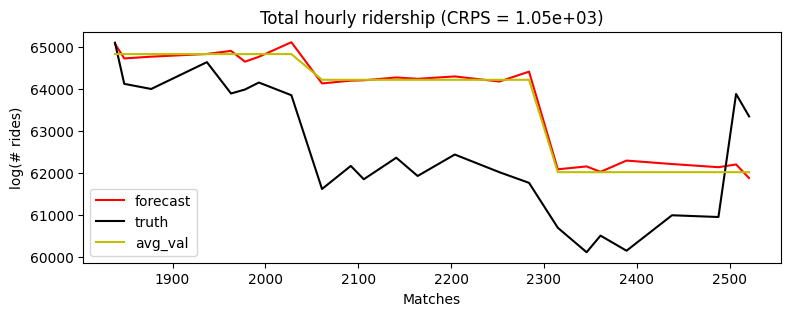

In [364]:
# covariates_test_with_test = torch.zeros(T2-T0, 0)  # empty
covariates_test = test_and_context_df[['avg_season_attendance_prev', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
       'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
       'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
       'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
       'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
       'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
       'late_afternoon', 'evening']]
# print(covariates_test)
covariates_test.loc[:,['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates_test[['noon', 'mid_afternoon',
       'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
       'away_team_superbowl_winner_last_season',
       'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype('int')

covariates_test_tensor = torch.tensor(covariates_test.values, dtype=torch.float)

y_context = test_and_context_df.loc[test_and_context_df['year']<2017, 'weekly_attendance']
y_context_tensor = torch.tensor(y_context.values, dtype=torch.float).unsqueeze(-1)
samples = forecaster(y_context_tensor, covariates_test_tensor, num_samples=100)
# samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
y_test = test_and_context_df.loc[test_and_context_df['year']>=2017, 'weekly_attendance']
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).unsqueeze(-1)
crps = eval_crps(samples, y_test_tensor)

plt.figure(figsize=(9, 3))
# plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(y_test.index, p50, 'r-', label='forecast')
plt.plot(y_test.index, y_test.values, 'k-', label='truth')
plt.plot(y_test.index, covariates_test.loc[y_test.index,'avg_season_attendance_prev'].values, 'y', label='avg_val')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Matches")
plt.legend(loc="best")


In [362]:
print(home_df.loc[home_df['year']==2017, 'weekly_attendance'].values.mean())
home_df.loc[home_df['year']==2018, 'avg_season_attendance_prev']

64217.625


2061    64217.625
2092    64217.625
2106    64217.625
2141    64217.625
2164    64217.625
2204    64217.625
2252    64217.625
2284    64217.625
Name: avg_season_attendance_prev, dtype: float64

In [332]:
att_df = pd.read_csv('../original_data/attendance.csv')    

In [338]:
att_df.loc[att_df['team_name'] == 'Cardinals']

,team,team_name,year,total,home,away,week,weekly_attendance
0,Arizona,Cardinals,2000,893926,387475,506451,1,77434.0
1,Arizona,Cardinals,2000,893926,387475,506451,2,66009.0
2,Arizona,Cardinals,2000,893926,387475,506451,3,NaN
3,Arizona,Cardinals,2000,893926,387475,506451,4,71801.0
4,Arizona,Cardinals,2000,893926,387475,506451,5,66985.0
...,...,...,...,...,...,...,...,...
10314,Arizona,Cardinals,2019,1000509,490586,509923,13,60944.0
10315,Arizona,Cardinals,2019,1000509,490586,509923,14,63880.0
10316,Arizona,Cardinals,2019,1000509,490586,509923,15,63345.0
10317,Arizona,Cardinals,2019,1000509,490586,509923,16,69022.0


In [339]:
games_df

,year,home_team_name,weekly_attendance,prev_game_attendance,avg_season_attendance_prev,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,zscore_yds_away,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening
0,2010,Bears,62080.0,62479.0,64444.6250,False,False,False,False,2.0,...,-1.711130,0.268122,-0.781831,0.62349,0.000000,1.000000,True,False,False,False
1,2010,Bills,69295.0,69848.0,67546.5000,False,False,False,False,1.0,...,-0.509086,-1.196211,-0.781831,0.62349,0.000000,1.000000,True,False,False,False
2,2010,Buccaneers,47211.0,62578.0,68354.3125,False,False,False,False,2.0,...,0.812194,0.696191,-0.781831,0.62349,0.000000,1.000000,True,False,False,False
3,2010,Patriots,68756.0,68756.0,71125.0000,False,False,False,True,2.0,...,1.305159,0.346325,-0.781831,0.62349,0.000000,1.000000,True,False,False,False
4,2010,Steelers,63609.0,64068.0,65711.6250,False,False,False,False,3.0,...,-0.631865,-0.514384,-0.781831,0.62349,0.000000,1.000000,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2019,Jaguars,58472.0,57866.0,69368.6875,False,False,False,True,1.0,...,-1.463446,0.412861,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False
2556,2019,Rams,68665.0,71501.0,68900.5625,False,False,False,False,1.0,...,2.922512,2.337384,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False
2557,2019,Ravens,70695.0,70545.0,65836.4375,False,False,False,False,3.0,...,-3.461590,0.230361,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False
2558,2019,Texans,71794.0,71769.0,69530.0000,False,False,False,False,2.0,...,1.824574,-0.980426,-0.781831,0.62349,-0.587785,-0.809017,False,True,False,False


In [320]:
print(y_test)

1838    65102.0
1848    64121.0
1877    63999.0
1937    64639.0
1963    63891.0
1978    63986.0
1993    64153.0
2028    63850.0
2061    61613.0
2092    62163.0
2106    61845.0
2141    62359.0
2164    61923.0
2204    62435.0
2252    62014.0
2284    61759.0
2315    60687.0
2346    60104.0
2361    60500.0
2389    60140.0
2438    60986.0
2488    60944.0
2507    63880.0
2521    63345.0
Name: weekly_attendance, dtype: float64


In [224]:
test_df

,year,home_team_name,weekly_attendance,prev_game_attendance,avg_season_attendance_prev,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_team_wins_last_3,...,zscore_yds_away,zscore_turnovers_away,day_sin,day_cos,month_sin,month_cos,noon,mid_afternoon,late_afternoon,evening
1548,2016,Cardinals,64864.0,64646.0,64277.8750,False,False,False,True,2.0,...,-0.143706,1.395391,-0.781831,0.623490,0.000000,1.000000,False,False,True,False
1561,2016,Cardinals,64230.0,64864.0,64277.8750,False,False,False,False,1.0,...,-0.930197,2.422407,-0.781831,0.623490,0.000000,1.000000,True,False,False,False
1593,2016,Cardinals,64622.0,64230.0,64277.8750,False,False,False,False,1.0,...,-0.160232,-0.257754,-0.781831,0.623490,0.951057,0.309017,False,True,False,False
1627,2016,Cardinals,64709.0,64622.0,64277.8750,False,False,False,False,1.0,...,-2.196939,0.379777,0.000000,1.000000,0.951057,0.309017,False,False,True,False
1640,2016,Cardinals,65089.0,64709.0,64277.8750,False,False,False,True,2.0,...,-2.238495,-0.968246,-0.781831,0.623490,0.951057,0.309017,False,False,True,False
1679,2016,Cardinals,65127.0,65089.0,64277.8750,False,False,False,False,1.0,...,-0.234418,-0.046639,-0.781831,0.623490,0.587785,-0.809017,False,True,False,False
1723,2016,Cardinals,64939.0,65127.0,64277.8750,False,False,False,True,1.0,...,-0.231903,0.477020,-0.781831,0.623490,-0.587785,-0.809017,False,True,False,False
1754,2016,Cardinals,65072.0,64939.0,64277.8750,False,False,False,False,1.0,...,1.045890,-0.211289,-0.781831,0.623490,-0.587785,-0.809017,False,True,False,False
1838,2017,Cardinals,65102.0,65072.0,67695.9375,False,False,False,True,2.0,...,-1.333282,-1.009466,0.000000,1.000000,0.000000,1.000000,False,False,True,False
1848,2017,Cardinals,64121.0,65102.0,67695.9375,False,False,False,False,1.0,...,-0.038461,-0.465130,-0.781831,0.623490,0.951057,0.309017,False,True,False,False


In [218]:
class Model1(ForecastingModel):
    def __init__(self, cov_dim, hidden_dim=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.trans_net = TransitionNet(cov_dim, hidden_dim)

    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        batch_shape = zero_data.shape[:-2]  # This should be [100] when sampling
        
        hidden_dim = self.hidden_dim
        last_year_avg_attendance = covariates[..., 0]
        other_covariates = covariates[..., 1:]
        
        # Mean function - ensure proper broadcasting
        prediction = last_year_avg_attendance.unsqueeze(-1).expand_as(zero_data)
        print(batch_shape)
        print("zero_data shape:", zero_data.shape)
        # Priors - allp expanded to batch_shape + hidden_dim
        init_dist = dist.Normal(0, 10).expand(batch_shape + (hidden_dim,)).to_event(1)
        
        # Sample with proper batch_shape
        trans_scale = pyro.sample(
            "trans_scale", 
            dist.LogNormal(-0.5 * math.log(24), 1)
            .expand(batch_shape)
        ).unsqueeze(-1)  # Add hidden_dim dimension
        
        trans_dist = dist.Normal(
            torch.zeros(batch_shape + (hidden_dim,)),
            trans_scale.expand(batch_shape + (hidden_dim,))
        ).to_event(1)
        
        obs_scale = pyro.sample(
            "obs_scale",
            dist.LogNormal(-2, 1)
            .expand(batch_shape)
        ).unsqueeze(-1)  # Add observation dimension
        
        obs_dist = dist.Normal(
            torch.zeros(batch_shape + (1,)),
            obs_scale
        ).to_event(1)

        # Generate transition matrices - handle batch dimension properly
        # Reshape covariates to merge sample and time dimensions
        orig_shape = other_covariates.shape
        other_covariates_reshaped = other_covariates.reshape(-1, orig_shape[-1])
        
        # Process through network
        trans_logits = self.trans_net(other_covariates_reshaped)
        
        # Reshape back to include sample dimension
        trans_matrix = trans_logits.reshape(*batch_shape, duration, hidden_dim, hidden_dim)
        
        # Stability adjustment
        eye = torch.eye(hidden_dim, device=trans_matrix.device)
        trans_matrix = 0.9 * trans_matrix + 0.1 * eye
        
        # Observation matrix - properly expanded
        obs_matrix = torch.eye(hidden_dim, 1, device=trans_matrix.device)
        obs_matrix = obs_matrix.expand(*batch_shape, hidden_dim, 1)
        
        # Build GaussianHMM
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix,
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)

In [118]:
a = torch.tensor([1.0013e-01, 8.9934e-01, 5.3601e-04])
a.sum()

tensor(1.0000)

In [85]:
torch.softmax(torch.tensor([0.9, -0.1, 4.0]), dim=0)

tensor([0.0424, 0.0156, 0.9420])